## Script to help understand the Surface Laplacian

"""
We use the surface Laplacian to transform the EEG data from a measures of
scalp potentials to an estimate of the underlying current sources and sinks.

Practically, the Surface Laplacian acts a spatial high-pass filter that, when applied to the data,
attenuates low-frequency, spatial components...the kind of activity that might give us a completely
blue or red head.
So, it attenuates activity that is broadly distributed across the scalp and conserves high-frequency spatial activity,
activity that is more localised.

<a href="https://github.com/alberto-ara/Surface-Laplacian"> Reference: https://github.com/alberto-ara/Surface-Laplacian</a>


In [1]:
from zipfile import ZipFile
import os
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(8, 6)},
        font_scale=1.5)
sns.set_style('whitegrid')

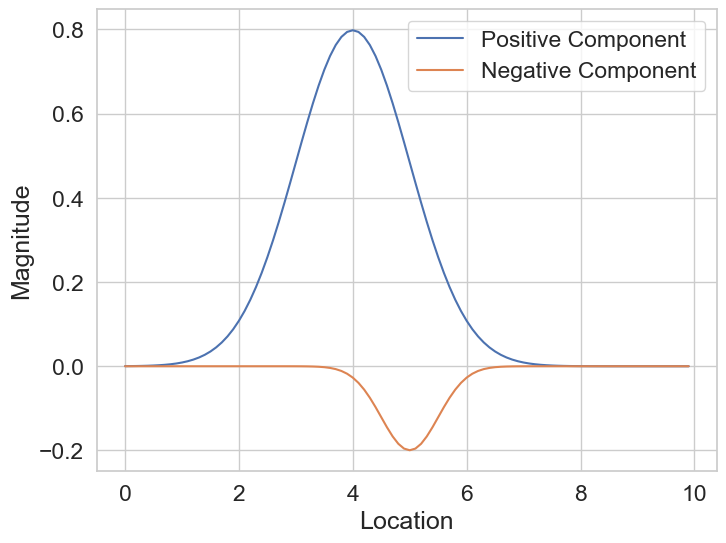

In [1]:
### Simulate the effect surface Laplacian

### Simulate One-Dimensional EEG Data
"""
    Simulate the spatial data from a group of adjacent electrodes (i.e. midline electrodes) as 1D data.
    The activity is made up of a very large broad positive component and a narrow, smaller negative component.
"""

electrode_spacing = .1
space = np.arange(0, 10, electrode_spacing)
pos_comp = 2 * stats.norm.pdf(space, loc=4, scale=1)        # The broad positive component
neg_comp = -.25 * stats.norm.pdf(space, loc=5, scale=.5)    # The narrow, lower magnitude negative component.

def do_label():
    """
        Define a function to show the plot labels
    """
    plt.legend(loc='upper right')
    plt.xlabel('Location')
    plt.ylabel('Magnitude')

fig_ground_truth = plt.figure()
for comp, label in zip([pos_comp, neg_comp], ['Positive Component', 'Negative Component']):
    plt.plot(space, comp, label=label)
do_label()
plt.show()

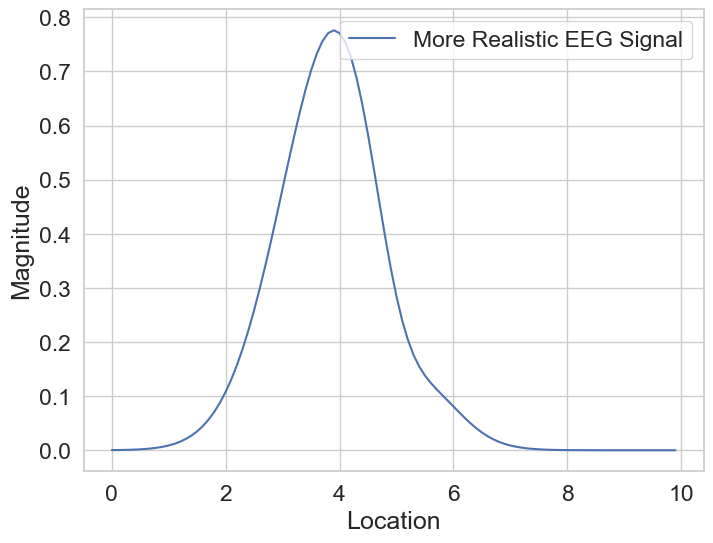

In [2]:
### Plot to reflect real EEG signal
"""
    In real EEG data, we do not see the narrow, smaller negative component.
    Both components are superimposed.
    Let's plot what we are more likely to see...
    Any sign of our negative component?
"""

sigeeg = pos_comp + neg_comp          # Superimpose both positive and negative components.

plt.plot(space, sigeeg, label='More Realistic EEG Signal')
do_label()


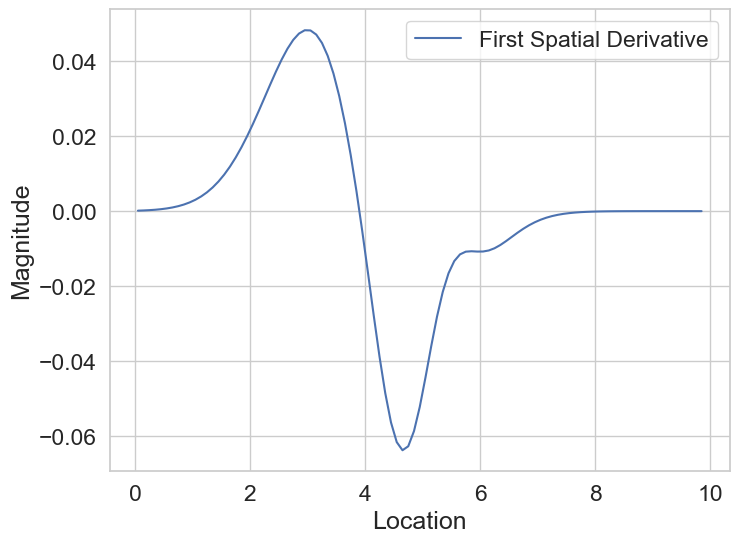

In [3]:
### Now we start to apply the Laplacian....
"""
    Start by calculating the first spatial derivative.
    This will give us the change between both electrodes...
"""

first_deriv = np.diff(sigeeg)
space_d1 = space[:-1] + .5 * electrode_spacing                 # Keep locations lined up with differentiated data
plt.plot(space_d1, first_deriv, label='First Spatial Derivative')
do_label()


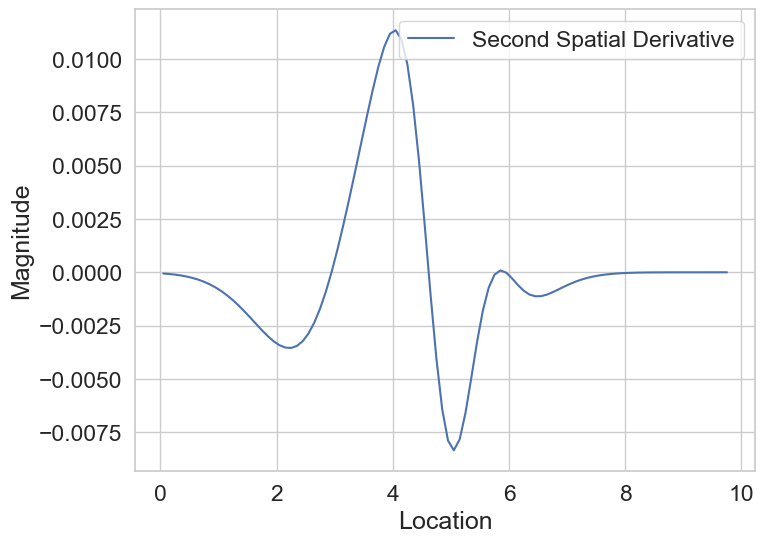

In [4]:

### We continue with our Laplacian...
"""
    We calculate the second spatial derivative of EEG signal; we find the
    derivative of the derivative.
    Note that we multiply the 2nd spatial derivative by -1 to make sure things are the right way up...
    At what locations (x-axis) do we see the postive component and negative component
"""

second_deriv = np.diff(first_deriv)
space_d2     = space[:-2] + .5 * electrode_spacing         # Keep the locations lined up with the differentiated data.
plt.plot(space_d2, -1 * second_deriv, label='Second Spatial Derivative')
do_label()


In [5]:
### Simulate Effect of Laplacian on Two-Dimensional Data
"""
    In this example, we are assuming that the scalp is flat.
    We often present scalp topographies as 2D images.
    Here we define a function (def) to plot a 2D array.
"""
%matplotlib widget
X = Y = np.arange(-10, 10.01, .1)
XY = np.array([(x, y) for x in X for y in Y])

def show(X):
    '''
        Plot an image given a 2D array
    '''
    mx = np.abs(X).max()
    im = plt.imshow(X, cmap='seismic', vmin=-mx, vmax=mx)
    plt.colorbar(im)


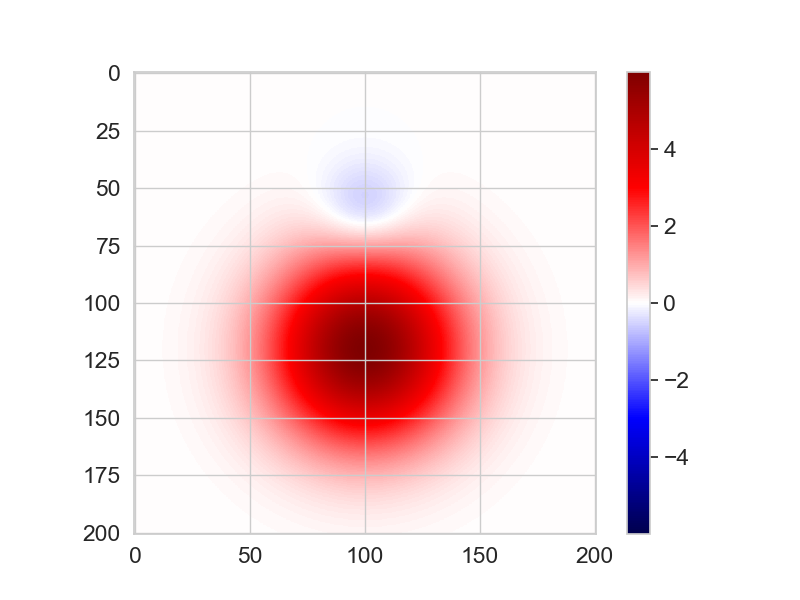

In [6]:
### Simulate 2D data
"""
    Here we simulate 2D with a large, broad positive component and a narrow, smaller negative
    component.
    We plot it in 2D space using the show() function.
"""
locs = [(0, -4), (0, 2)]        # Center of each component
peaks = [-1, 6]                 # Peak amplitudes
scales = [2, 8]                 # Standard deviations
V = np.zeros(XY.shape[0])       # Voltages

for loc, peak, scale in zip(locs, peaks, scales):
    cov = np.eye(2) * scale
    thisV = stats.multivariate_normal.pdf(XY, mean=loc, cov=cov)
    gain = peak / thisV.max()
    V += thisV * gain
wV = V.reshape(len(X), len(X)).T # Voltage as a 2D grid
show(wV)


In [7]:
### Find the First Spatial Derivative of the Data
"""
    Here, to construct our Laplacian, we have to combine one-dimensional partial derivatives.
    We create a function combine_part() to do this.
"""
def combine_parts(dx, dy):


    m = dx.shape[0]
    assert(dy.shape[1]==m)
    return dx[:m, :m] + dy[:m, :m]

dv_dx = np.diff(wV, axis=0)[:-1, :]      # Drop the last value in 1st dimension (x)
dv_dy = np.diff(wV, axis=1)[:, :-1]      # Drop the last value in 2nd dimension (y)
grad = combine_parts(dv_dx, dv_dy)
show(grad)


In [8]:
### Find the Second Spatial Derivative of the Data

ddv_ddx = np.diff(dv_dx, axis=0)[:-1, :]
ddv_ddy = np.diff(dv_dy, axis=1)[:, :-1]
L = combine_parts(ddv_ddx, ddv_ddy)
laplace = -1*L                       # Remember to multiple the 2nd derivative by -1 to invert polarity.
show(laplace)
